# Загрузим библиотеки для предобработки данных, построения модели 


In [2]:
!pip install shap
!pip install pytorch_transformers/
!pip install transformers
!pip install pymorphy2
!pip install razdel
!pip install torchmetrics
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 15.3 MB/s eta 0:00:00
ERROR: Invalid requirement: 'pytorch_transformers/'
Hint: It looks like a path. File 'pytorch_transformers/' does not exist.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 112.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3

In [ ]:
import numpy as np 
import pandas as pd 
import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import re 
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Данные представляют собой набор текстов с одной из двух меток

*не забудьте загрузить их в среду, если захотите запустить ноутбук

In [ ]:
data = pd.read_csv('mental_health.csv')
data.dropna()

data.head(10)

text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1
5  hey rredflag sure right place post this goes  ...      1
6  feel like someone needs hear tonight feeling r...      0
7  deserve liveif died right noone would carei re...      1
8  feels good ive set dateim killing friday nice ...      1
9  live guiltok made stupid random choice  its ge...      1

In [ ]:
# оценим сбалансированность датасета 
data.label.value_counts()

0    14139
1    13838
Name: label, dtype: int64

In [ ]:
# приведем все к нижнему регистру
data['text'] = data['text'].apply(lambda x:x.lower())

# возьмем все слова в начальной форме
lemm = WordNetLemmatizer()
data['text'] = data['text'].apply(lambda x: lemm.lemmatize(x))

x = data['text']
y = data['label']

In [ ]:
# токенизируем слова: превратим в набор чисел
token = Tokenizer(num_words=10000, oov_token="<OOV>")
token.fit_on_texts(x)


word_index = token.word_index
train_seq = token.texts_to_sequences(x)

# паддинг, чтобы все последовательности были одинаковой длины
train_padd = pad_sequences(train_seq,padding="post", truncating="post", maxlen=50)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(train_padd, y, test_size=0.33)

In [ ]:
# построим модель lstm: возьмем билинейную, чтобы смотреть на каждую последовательность с двух сторон
model = keras.models.Sequential()

model.add(keras.layers.Embedding(10000, 128))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(128)))
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [ ]:
# сборка(в keras и tf модели являются статичными, это значит, что архитектуру после поменять будет уже нельзя)


# в качестве функции потерь возьмем бинарную кроссэнтропию, так как у нас задача бинарной классификации,
# а метрикой будет accuracy(отношение кол-ва верных ответов ко всем ответам сети)
model.compile("rmsprop", "binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=4, validation_data=(x_val, y_val))

Epoch 1/4
586/586 [==============================] - 298s 473ms/step - loss: 0.3016 - accuracy: 0.8785 - val_loss: 0.2391 - val_accuracy: 0.9095
Epoch 2/4
586/586 [==============================] - 210s 358ms/step - loss: 0.1897 - accuracy: 0.9309 - val_loss: 0.2039 - val_accuracy: 0.9195
Epoch 3/4
586/586 [==============================] - 234s 398ms/step - loss: 0.1475 - accuracy: 0.9465 - val_loss: 0.2066 - val_accuracy: 0.9180
Epoch 4/4
586/586 [==============================] - 233s 397ms/step - loss: 0.1139 - accuracy: 0.9604 - val_loss: 0.2739 - val_accuracy: 0.9102


# На валидации получаем точность выше 90%, отлично!!!

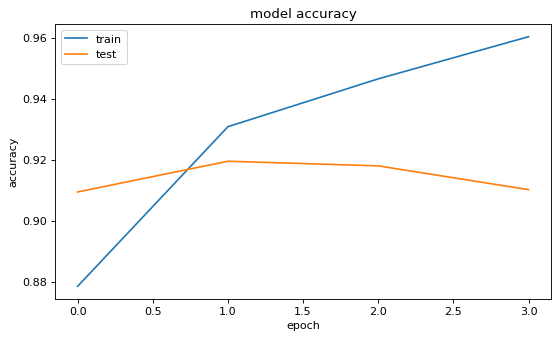

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 10), dpi=80)

# посмотрим на прогресс при обучении

plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# А теперь перейдем к современным моделям(к трансформерам 😊)

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertConfig, AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
from tqdm import trange
import re
from IPython.display import clear_output
import yaml
from sklearn.metrics import roc_auc_score
import torchmetrics
from torchmetrics import ConfusionMatrix
from sklearn.metrics import classification_report





from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
MODEL_NAME = "bert-base-cased"

In [5]:
# снова загрузим данные
data = pd.read_csv('mental_health.csv')
data.dropna()

data.head(10)

text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1
5  hey rredflag sure right place post this goes  ...      1
6  feel like someone needs hear tonight feeling r...      0
7  deserve liveif died right noone would carei re...      1
8  feels good ive set dateim killing friday nice ...      1
9  live guiltok made stupid random choice  its ge...      1

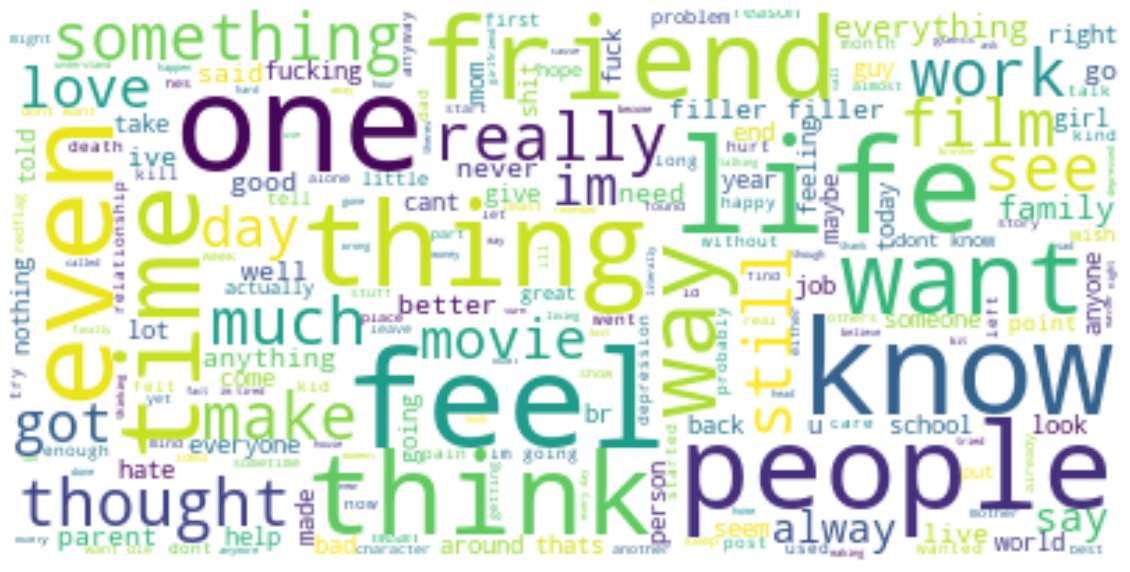

In [6]:
# визуализируе облака слов(от размера шрифта зависит частота появления слов в тексте)
from wordcloud import WordCloud

text = " ".join(cat for cat in data["text"])

wordcloud = WordCloud(max_font_size=50, max_words=500, background_color="white").generate(text)
plt.figure(figsize=(20,20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

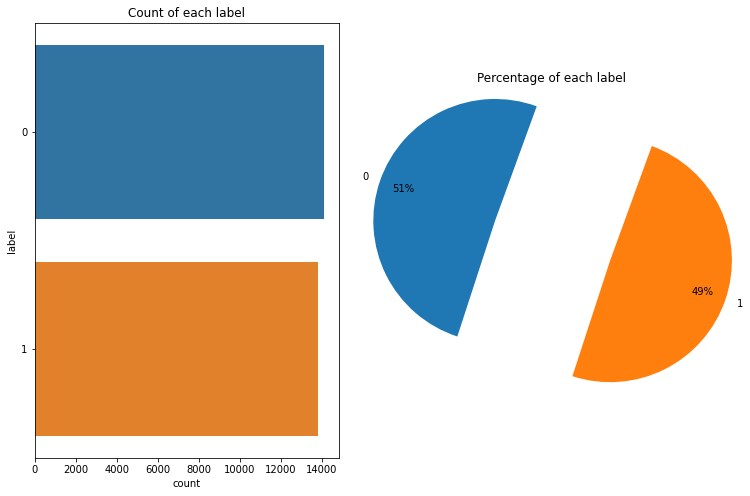

In [7]:
import seaborn as sns

df = pd.DataFrame({'text': data.text.tolist(), 'label': data.label.tolist()})


fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
explode = list((np.array(list(df["label"].value_counts()))/sum(list(df["label"].value_counts())))[::-1])


classes = df['label'].unique().tolist()
n_values = []

for cl in classes:
    n = df[df['label'] == cl].count().tolist()[1]
    n_values.append(n)

ax2.pie(n_values,  explode=explode, startangle=70, labels=classes, autopct='%1.0f%%', pctdistance=0.8)
ax2.add_artist(plt.Circle((0,0),0.4,fc='white'))
sns.countplot(y="label", data=df, ax=ax1)
ax1.set_title("Count of each label")
ax2.set_title("Percentage of each label")
plt.show()

In [8]:
train_x, val_x, train_y, val_y = train_test_split(df.text.values, df.label.values, random_state=0, test_size=0.25, stratify=df.label.values)

In [9]:
train_x = train_x.tolist()
train_y = [int(el) for el in train_y.tolist()]

In [10]:
# восстанавливаем балланс классов

from imblearn.over_sampling import RandomOverSampler


ovs = RandomOverSampler(sampling_strategy = "auto", random_state = 11)
x_rovs, y_rovs = ovs.fit_resample(np.array(train_x).reshape(-1, 1), np.array(train_y))

In [11]:
from collections import Counter

print("Кол-во примеров каждого класса: ", Counter(y_rovs))


print("Кол-во всех примеров после оверсемплинга: ", len(x_rovs))
print("Кол-во всех примеров в реальных данных: ", len(train_x))

Кол-во примеров каждого класса:  Counter({1: 10604, 0: 10604})
Кол-во всех примеров после оверсемплинга:  21208
Кол-во всех примеров в реальных данных:  20982


In [12]:
train_x = x_rovs.tolist()
train_y = y_rovs

In [13]:
from sklearn.utils import shuffle

train_x, train_y = shuffle(train_x, train_y)

In [14]:
train_y[-30:]

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1])

In [15]:
import time
import requests

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
except requests.exceptions.ReadTimeout:
    print("\n Переподключение к серверам \n")
    time.sleep(3)

In [16]:
from keras_preprocessing.sequence import pad_sequences

MAX_LEN = 128
train_attention_masks = []
  
  
train_tokenized_texts = [tokenizer.tokenize(sent[0]) for sent in train_x]
train_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in train_tokenized_texts]

train_inputs= pad_sequences(
    train_input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
    ) 

train_masks = [[float(i>0) for i in seq] for seq in train_inputs]





val_attention_masks = []
  
val_tokenized_texts = [tokenizer.tokenize(sent) for sent in val_x]
val_input_ids = [tokenizer.convert_tokens_to_ids(x) for x in val_tokenized_texts]

val_inputs = pad_sequences(
    val_input_ids,
    maxlen=MAX_LEN,
    dtype="long",
    truncating="post",
    padding="post"
    ) 

val_masks = [[float(i>0) for i in seq] for seq in val_inputs]



Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors


In [17]:
train_inputs = torch.tensor(train_inputs)
train_masks = torch.tensor(train_masks)
train_labels = torch.tensor(train_y)

val_inputs = torch.tensor(val_inputs)
val_masks = torch.tensor(val_masks)
val_labels = torch.tensor(val_y)

batch_size = 16


train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = RandomSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

print('Train dataloader: ', len(train_dataloader))
print('Val dataloader: ', len(val_dataloader))

Train dataloader:  1326
Val dataloader:  438


In [18]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2, output_attentions=True)
model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [19]:
# Parameters:
lr = 3e-5
epochs = 2

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs


optimizer = AdamW(model.parameters(), lr=lr)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

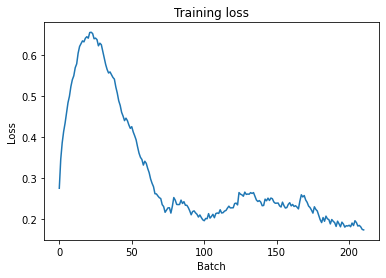

Epoch:  0
Loss на обучающей выборке: 0.03795


Prediction Iteration:   0%|          | 0/438 [00:00<?, ?it/s]

Best_score:  0.9333809864188706 

Current accuracy:  0.9333809864188706
              precision    recall  f1-score   support

     class 0       0.94      0.93      0.93      3535
     class 1       0.93      0.94      0.93      3460

    accuracy                           0.93      6995
   macro avg       0.93      0.93      0.93      6995
weighted avg       0.93      0.93      0.93      6995



KeyboardInterrupt: ignored

In [22]:
from sklearn.metrics import matthews_corrcoef


train_loss_set = []
train_loss = 0

best_score = 0
best_score_sep = 0

for epoch in range(epochs):
  model.train()
  for step ,batch in enumerate(train_dataloader):
 
      batch = tuple(t.to(device) for t in batch)

      b_input_ids, b_input_mask, b_labels = batch
      

      optimizer.zero_grad()
      
      # Forward pass
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      train_loss_set.append(loss[0].item())  
      
      # Backward pass
      loss[0].backward()
      
      # Обновляем параметры и делаем шаг используя посчитанные градиенты
      optimizer.step()
      scheduler.step()

      # Обновляем loss
      train_loss += loss[0].item()
      
      if(step+1)%30 == 0:
        # Рисуем график
        clear_output(True)
        smoothing_train_loss_set = double_exponential_smoothing(train_loss_set, 0.05, 0.05)
        plt.plot(smoothing_train_loss_set)
        plt.title("Training loss")
        plt.xlabel("Batch")
        plt.ylabel("Loss")
        plt.show()

        print('Epoch: ', epoch)
        print("Loss на обучающей выборке: {0:.5f}".format(train_loss / (len(train_dataloader)*(epoch+1))))


        all_logits = None
    
        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        all_labels = []
        for step, batch in enumerate(tqdm(val_dataloader, desc="Prediction Iteration")):
            input_ids, input_mask, labels = batch
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            labels = labels.type(torch.LongTensor)
            labels = labels.to(device)

            with torch.no_grad():
                logits = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels) 
                logits = logits[1]

                if all_logits is None:
                    all_logits = logits.detach().cpu().numpy()
                else:
                    all_logits = np.concatenate((all_logits, logits.detach().cpu().numpy()), axis=0)
            all_labels.extend(labels.cpu().numpy())



        count = [0, 0]
        all_preds = []

        for log_i in range(len(all_logits)):
            log = all_logits.argmax(1)[log_i]

            corr_or_not = log.item()==all_labels[log_i]
            if corr_or_not.item():
                count[all_labels[log_i]] += 1 

            all_preds.append(log.item())

        accuracy_value = sum(count)/len(all_labels)
      
        for person_i in range(2):
            count[person_i] /= all_labels.count(person_i)

        
        if accuracy_value > best_score:
            best_score = accuracy_value
            best_score_sep = count
         

        print('Best_score: ', best_score, '\n')

        print('Current accuracy: ', accuracy_value)


        target = torch.tensor(all_labels)
        preds = torch.tensor(all_preds)


        target_names = ['class 0', 'class 1']
        print(classification_report(target, preds, target_names=target_names))

# Перейдем к визуализации:
 
посмотрим на механизм self-attention, на какие конкретно слова обращала внимание сеть


In [ ]:
!pip install bertviz

In [25]:
# Load model and retrieve attention weights

from bertviz import head_view, model_view



sentence_a = "My fucking life is suck"
sentence_b = "I love you man"


inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']


model.to('cpu')
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [26]:
head_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>

In [27]:
model_view(attention, tokens, sentence_b_start)

<IPython.core.display.Javascript object>